# Ising model simulation: Classical Monte Carlo

The Ising model is a paradigmatic lattice model of magnetic behavior. We shall study a square lattice (with periodic boundary conditions) with $N = L \times L$ sites, with an Ising spin $S=\pm 1$ situated on each site. Considering nearest-neighbor interactions only, the total energy is given by:

$ E = J \sum_{\langle i, j \rangle} S_i S_j $,

where the sum is over all pairs of neighboring sites. Here $J$ is the Ising coupling, where $J=+1$ corresponds to an antiferromagnetic interaction, while $J=-1$ is a ferromagnetic coupling. In this notebook we will study the antiferromagnetic case, and study the transition from a totally disordered high temperature regime to an alternating checkerboard pattern at low temperatures. 

If a spin at site $(x, y)$ is flipped, the change in total energy $\Delta E$ etween this new configuration and the old configuration is:

$ J( [S^{new}_{x,y} S_{x+1, y} + S^{new}_{x,y}S_{x-1, y} + S^{new}_{x,y}S_{x,y+1} + S^{new}_{x,y}S_{x,y-1}] - [S^{old}_{x,y} S_{x+1, y} + S^{old}_{x,y}S_{x-1, y} + S^{old}_{x,y}S_{x,y+1} + S^{old}_{x,y}S_{x,y-1}]) $.

That is:

$\Delta E = J (S^{new}_{x,y} - S^{old}_{x,y}) [S_{x+1, y} + S_{x-1, y} + S_{x,y+1} + S_{x,y-1}]$.

Now, the spin we choose to flip is either $S^{old}_{x,y}=1$ or $S^{old}_{x, y}=-1$. 

If $S^{old}_{x,y} = 1$, then the proposed update has $S^{new}_{xy} = -1$, and so $S^{new}_{x,y} - S^{old}_{x,y} = -2$. However if $S^{old}_{x,y} = -1$, then the proposed update has $S^{new}_{xy} = 1$, and so $S^{new}_{x,y} - S^{old}_{x,y} = 2$. Hence in either case, we can express the change in energy as:

$ \Delta E = -2J(S^{old}_{x,y}) [S_{x+1, y} + S_{x-1, y} + S_{x,y+1} + S_{x,y-1}] $.

For any configuration of spins $m$ with corresponding energy $E_m$, the probability of the state is given by $P_m = \frac{1}{Z} e^{-\beta E_m}$, where $Z = \sum_m e^{-\beta E_m}$ is the partition function. Our Monte Carlo method will propose random flips to individuals spins in the lattice, and either accept or reject the update according to the Metropolis-Hastings criterion. That is, for each Monte Carlo step, we propose flipping a spin i.e. updating the configuration $m$ to a new configuration $n$. We accept this move if $E_n \leq E_m$, otherwise we accept with probability $e^{(-\beta \Delta E)}$.

In [43]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [123]:
def simulation(J, L, T_min, T_max, N_temps, N_bin, N_warm, N_meas, T2_min, T2_max, N_warm_2, N_meas_2):
                
        
    # Define array of N_temps temperatures to sweep through from T_min to T_max:     
        
    T_array = np.linspace(T_min, T_max, N_temps)
    
    
    # Initialize arrays to store final magnetization M, staggered magnetization, and their errors, for each temperature:
    
    m_array = np.zeros(N_temps)
    sm_array = np.zeros(N_temps)
    me_array = np.zeros(N_temps)
    sme_array = np.zeros(N_temps)
    
    # We will perform N_meas measurements of these quantities per temperature, sorting them into N_bin separate bins each
    # containing (N_meas/N_bin) = bin_size individual measurements. E.g. for N_meas=100K, N_bin=100, then bin_size=1000.
    # For each temperature we can obtain <M> by averaging over the binned M values and calculating standard error of the mean.
    
    # For each temperature, we store will N_bin snapshots of configurations, along with the value of the temperature T.
    # In binned_configurations_array, each row is a particular configuration (flattened to 1d) with
    # T appended as the final element. For example if N_temps=41, N_bin=100, L=12, then binned_configurations_array 
    # has dimension (4100, 145). Note L is the linear spatial dimension i.e. a square lattice has L*L sites.
    
    binned_configurations_array = np.zeros(shape=((N_temps*N_bin), ((L*L)+1)))
    
    
    
    # Define an array of alternating 1 and -1 entries used for calculating staggered magnetization:
    
    alternating = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            alternating[i][j] = ((-1)**(i+j))
            
            
                        
    # Sweep through each temperature:
    
    for t in range(N_temps):
    
        T = T_array[t]
        
        print('####################')
        print(f'##### T = {T:.2f} #####')
        print('####################')
    
        beta = 1 / T   # Inverse temperature
        
        # Initialize lattice with randomized spin configuration:

        spins = np.zeros(shape=(L, L), dtype=int)
        for x in range(L):
            for y in range(L):
                spins[x][y] = random.choice([1,-1])
                
        initial_spins = np.copy(spins)

        
        
        # Near critical temperature perform additional sweeps:
        
        if T2_min <= T <= T2_max:
            Num_warm = N_warm_2
            Num_meas = N_meas_2
        else:
            Num_warm = N_warm 
            Num_meas = N_meas
            
        bin_size = int(Num_meas/N_bin)
        
        mag_binned = np.zeros(N_bin)
        stag_mag_binned = np.zeros(N_bin)
        
        
        
        # Perform Num_warm thermalization sweeps:
        
        for i in range(Num_warm):

            x = random.randrange(L)
            y = random.randrange(L)

            S_old = spins[x][y]

            DeltaE = -2 * J * S_old * (spins[(x+1)%L][y] + spins[(x-1)%L][y] + spins[x][(y+1)%L] + spins[x][(y-1)%L])

            if DeltaE < 0:

                spins[x][y] = -1 * S_old

            elif random.random() < np.exp(-1 * beta * DeltaE):

                spins[x][y] = -1 * S_old
            
        warmed_spins = np.copy(spins)
        
        
        
        # Perform Num_meas measurement sweeps:
        
        for n in range(N_bin):

            for m in range(bin_size):

                x = random.randrange(L)
                y = random.randrange(L)

                S_old = spins[x][y]

                DeltaE = -2 * J * S_old * (spins[(x+1)%L][y] + spins[(x-1)%L][y] + spins[x][(y+1)%L] + spins[x][(y-1)%L])

                if DeltaE < 0:

                    spins[x][y] = -1 * S_old

                elif random.random() < np.exp(-1 * beta * DeltaE):

                    spins[x][y] = -1 * S_old
                                        
                stag_mag = (np.sum(alternating * spins) / (L*L))
                mag = np.sum(spins) / (L*L)

                mag_binned[n] += mag
                stag_mag_binned[n] += np.abs(stag_mag) 
            
            
            bin_config = spins.flatten()
            bin_config = np.append(bin_config, T)
            binned_configurations_array[(t * N_bin) + n] = bin_config
                    
                
            mag_binned[n] /= bin_size
            stag_mag_binned[n] /= bin_size
            
            
        measured_spins = np.copy(spins)    
            
        
        
        # Calculate average of binned measurements and standard error of the mean:
        
        mag_avg = np.mean(mag_binned)
        mag_error = np.std(mag_binned, ddof=1) / np.sqrt(N_bin)

        stag_mag_avg = np.mean(stag_mag_binned)
        stag_mag_error = np.std(stag_mag_binned, ddof=1) / np.sqrt(N_bin)
        
        
        
        # Display the intial, post-warmup, and post-measurement spin configurations:
                
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].set_xticks(ticks=range(L))
        axs[0].set_yticks(ticks=range(L))
        axs[0].imshow(initial_spins, origin='lower', cmap='bwr')
        axs[0].set_title('Initial random configuration', fontsize=10)
        axs[1].set_xticks(ticks=range(L))
        axs[1].set_yticks(ticks=range(L))
        axs[1].imshow(warmed_spins, origin='lower', cmap='bwr')
        axs[1].set_title('Configuration after warmup', fontsize=10)
        axs[2].set_xticks(ticks=range(L))
        axs[2].set_yticks(ticks=range(L))
        axs[2].imshow(measured_spins, origin='lower', cmap='bwr')
        axs[2].set_title('Configuration after measurements', fontsize=10)
        plt.show()
        
        
        
        # Print measurement statistics:

        print(f'T = {T:.2f} statistics: ')
        print(f'mag_avg = {mag_avg:.6g}')
        print(f'mag_error = {mag_error:.6g}')
        print(f'stag_mag_avg = {stag_mag_avg:.6g}')
        print(f'stag_mag_error = {stag_mag_error:.6g}')
        print('\n\n\n\n\n')
        
        
        
        # Append measurements for this temperature T to arrays:
        
        m_array[t] = mag_avg
        me_array[t] = mag_error
        sm_array[t] = stag_mag_avg
        sme_array[t] = stag_mag_error
        
        
    return binned_configurations_array, T_array, m_array, me_array, sm_array, sme_array

####################
##### T = 1.00 #####
####################


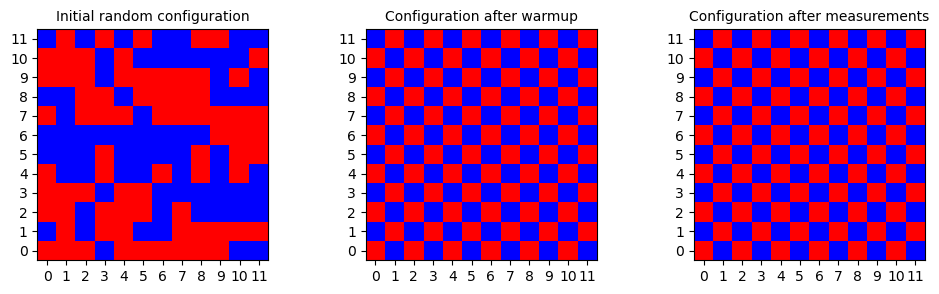

T = 1.00 statistics: 
mag_avg = 0.000281528
mag_error = 0.000156487
stag_mag_avg = 0.999119
stag_mag_error = 0.000213189






####################
##### T = 1.10 #####
####################


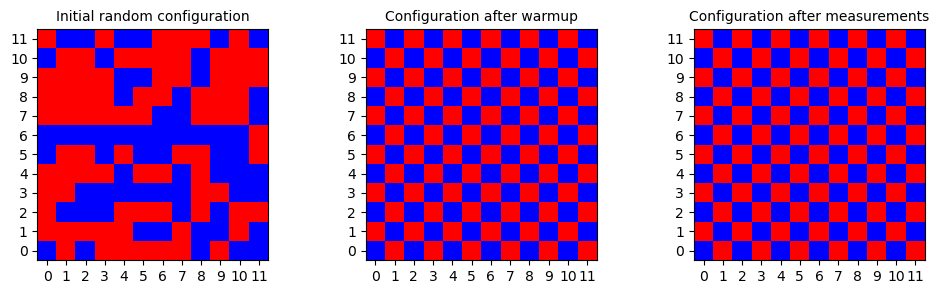

T = 1.10 statistics: 
mag_avg = 9.34722e-05
mag_error = 0.000179374
stag_mag_avg = 0.998655
stag_mag_error = 0.000196276






####################
##### T = 1.20 #####
####################


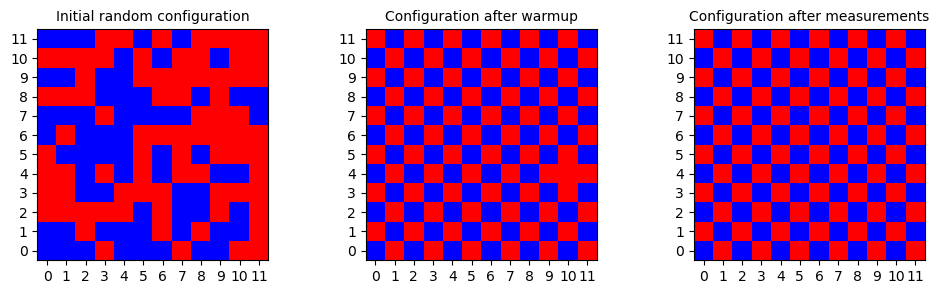

T = 1.20 statistics: 
mag_avg = -1.98611e-05
mag_error = 0.000289476
stag_mag_avg = 0.996848
stag_mag_error = 0.000340781






####################
##### T = 1.30 #####
####################


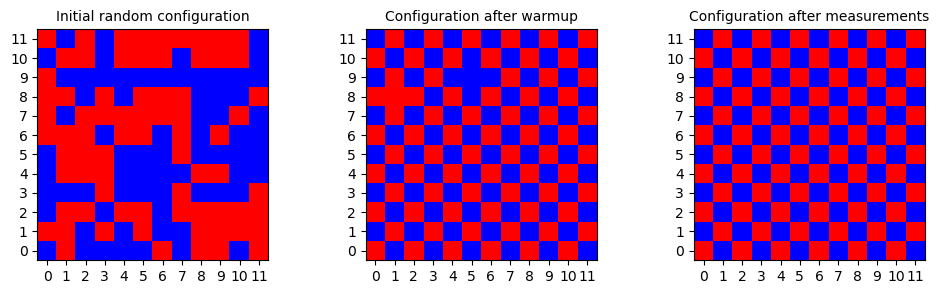

T = 1.30 statistics: 
mag_avg = -5.625e-05
mag_error = 0.00034161
stag_mag_avg = 0.995277
stag_mag_error = 0.000485213






####################
##### T = 1.40 #####
####################


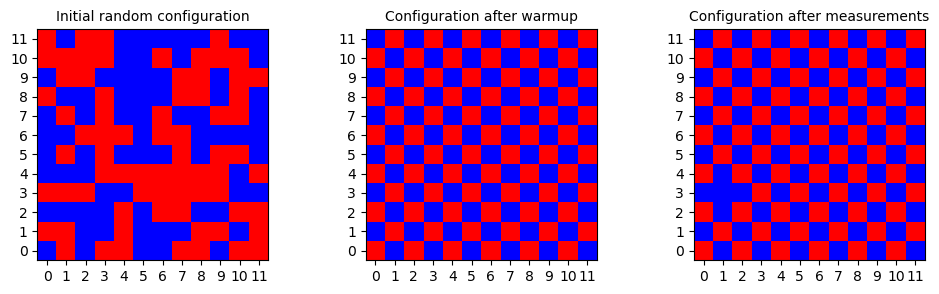

T = 1.40 statistics: 
mag_avg = 0.000828889
mag_error = 0.000495735
stag_mag_avg = 0.991116
stag_mag_error = 0.000654733






####################
##### T = 1.50 #####
####################


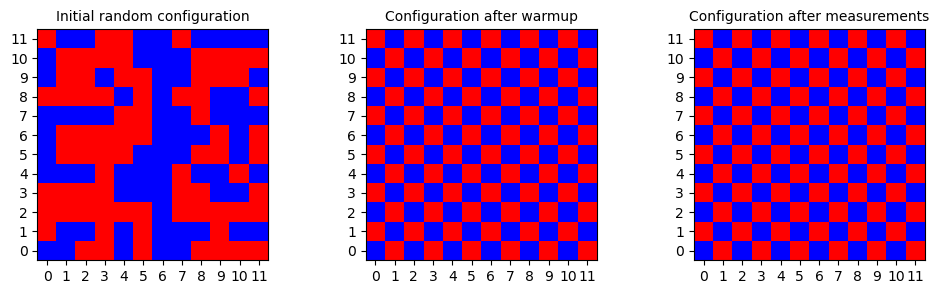

T = 1.50 statistics: 
mag_avg = -0.000739722
mag_error = 0.000494956
stag_mag_avg = 0.987654
stag_mag_error = 0.000986364






####################
##### T = 1.60 #####
####################


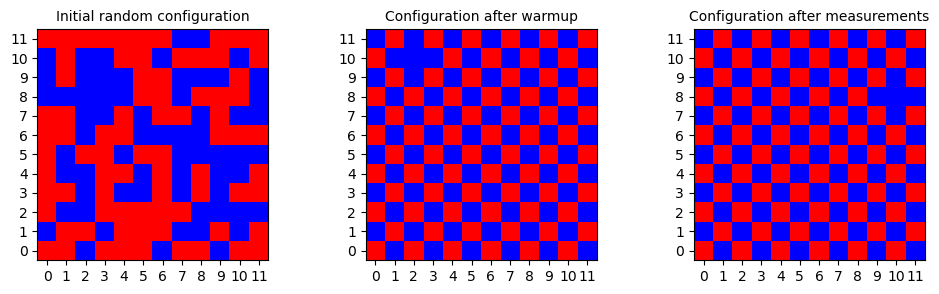

T = 1.60 statistics: 
mag_avg = -0.00138028
mag_error = 0.000665744
stag_mag_avg = 0.978592
stag_mag_error = 0.00132878






####################
##### T = 1.70 #####
####################


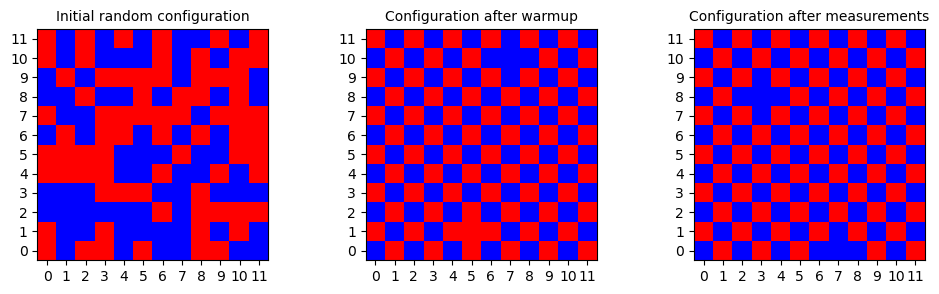

T = 1.70 statistics: 
mag_avg = 0.000306944
mag_error = 0.000823211
stag_mag_avg = 0.971016
stag_mag_error = 0.00156415






####################
##### T = 1.80 #####
####################


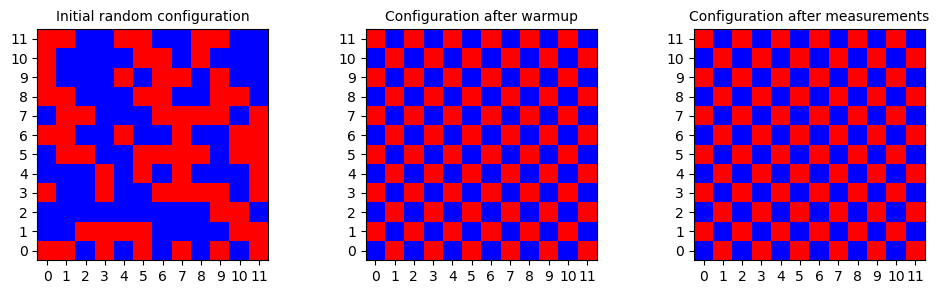

T = 1.80 statistics: 
mag_avg = -0.00082625
mag_error = 0.000804628
stag_mag_avg = 0.962018
stag_mag_error = 0.00237077






####################
##### T = 1.90 #####
####################


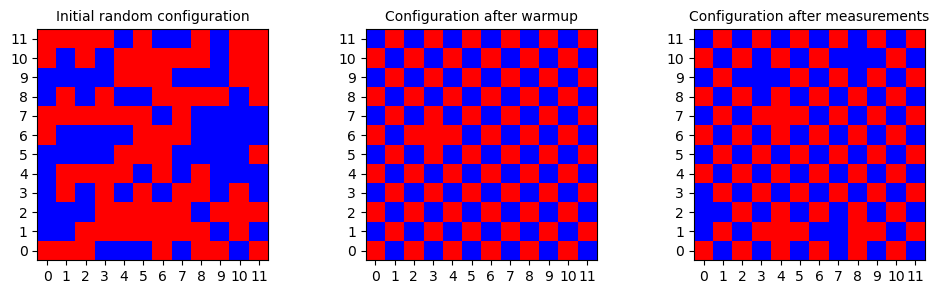

T = 1.90 statistics: 
mag_avg = -0.00130208
mag_error = 0.000769367
stag_mag_avg = 0.942865
stag_mag_error = 0.00301874






####################
##### T = 2.00 #####
####################


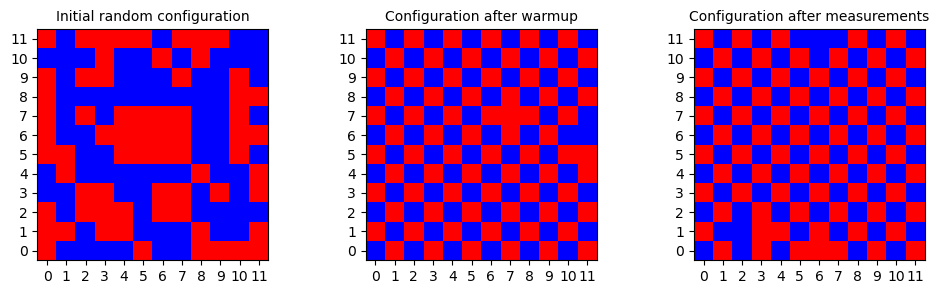

T = 2.00 statistics: 
mag_avg = 0.000745382
mag_error = 0.000474891
stag_mag_avg = 0.902999
stag_mag_error = 0.00792863






####################
##### T = 2.10 #####
####################


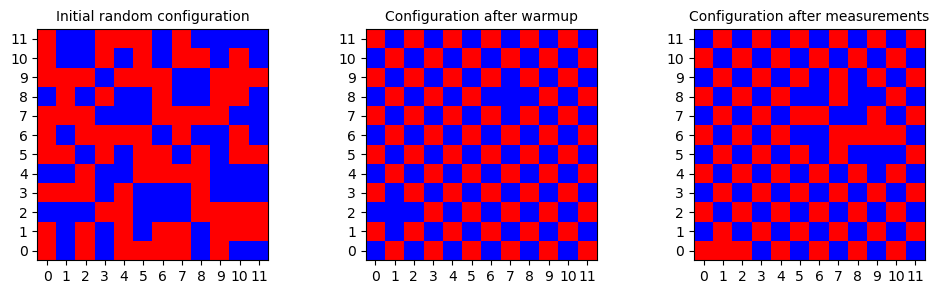

T = 2.10 statistics: 
mag_avg = 0.000125243
mag_error = 0.000567206
stag_mag_avg = 0.850579
stag_mag_error = 0.0137699






####################
##### T = 2.20 #####
####################


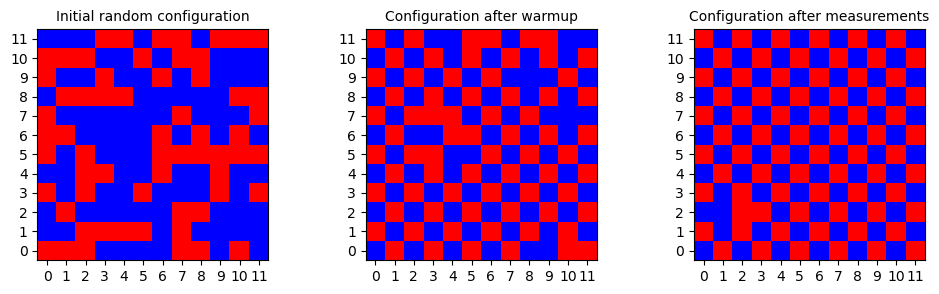

T = 2.20 statistics: 
mag_avg = -0.000142535
mag_error = 0.000595763
stag_mag_avg = 0.804981
stag_mag_error = 0.0133615






####################
##### T = 2.30 #####
####################


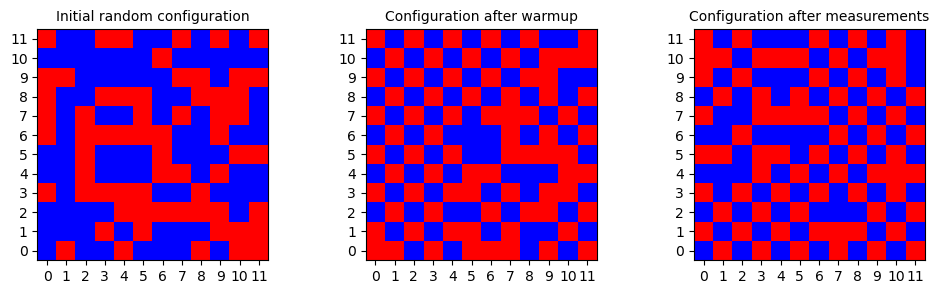

T = 2.30 statistics: 
mag_avg = 0.000666319
mag_error = 0.000589287
stag_mag_avg = 0.714979
stag_mag_error = 0.0156316






####################
##### T = 2.40 #####
####################


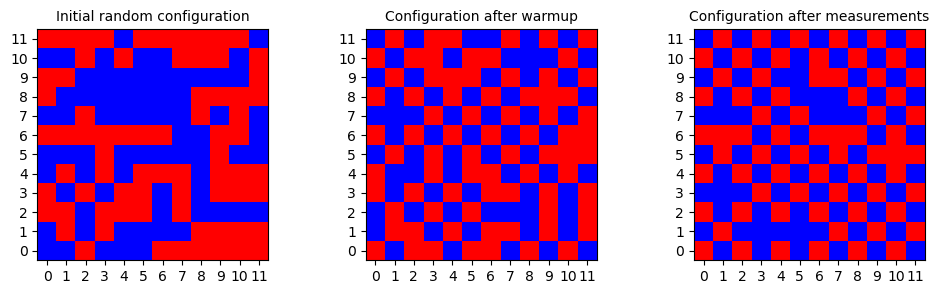

T = 2.40 statistics: 
mag_avg = -0.00013934
mag_error = 0.000573951
stag_mag_avg = 0.656257
stag_mag_error = 0.0173018






####################
##### T = 2.50 #####
####################


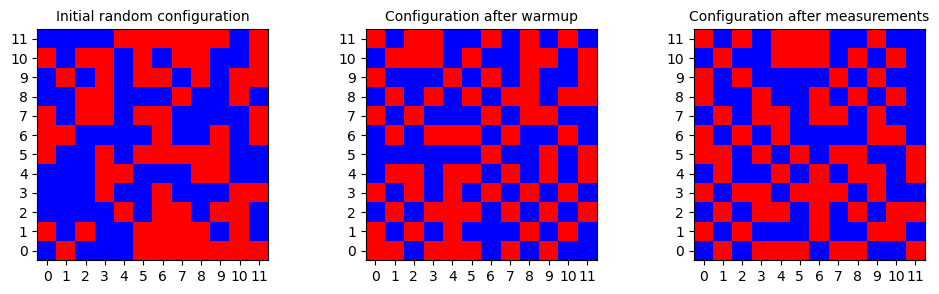

T = 2.50 statistics: 
mag_avg = -0.000990694
mag_error = 0.000625279
stag_mag_avg = 0.472932
stag_mag_error = 0.0200595






####################
##### T = 2.60 #####
####################


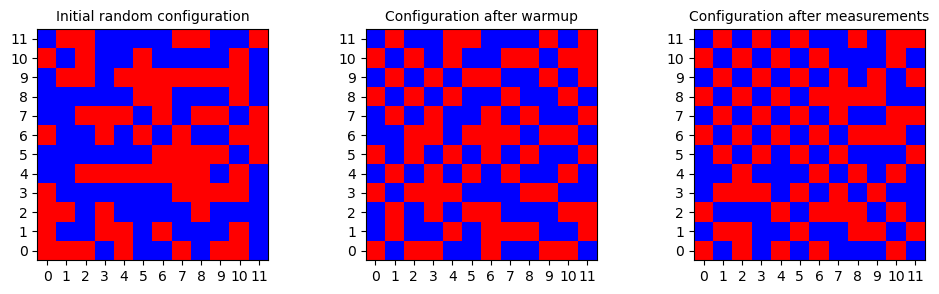

T = 2.60 statistics: 
mag_avg = 0.000302569
mag_error = 0.000659235
stag_mag_avg = 0.433093
stag_mag_error = 0.0177772






####################
##### T = 2.70 #####
####################


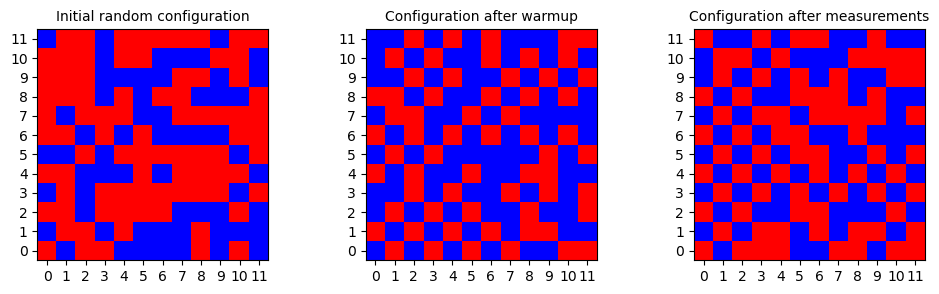

T = 2.70 statistics: 
mag_avg = -0.00102382
mag_error = 0.000647136
stag_mag_avg = 0.357998
stag_mag_error = 0.0147868






####################
##### T = 2.80 #####
####################


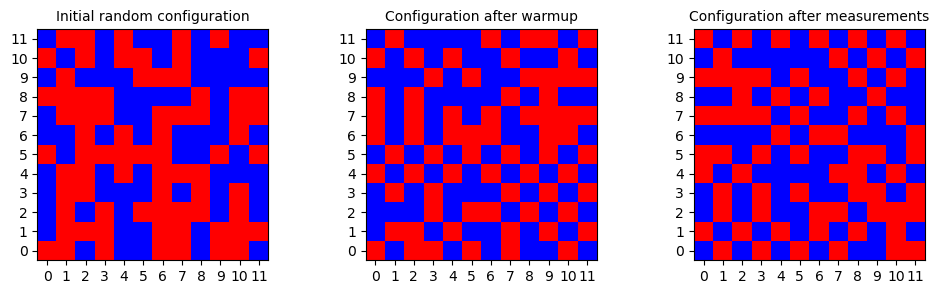

T = 2.80 statistics: 
mag_avg = 0.000776076
mag_error = 0.000747222
stag_mag_avg = 0.276733
stag_mag_error = 0.0112856






####################
##### T = 2.90 #####
####################


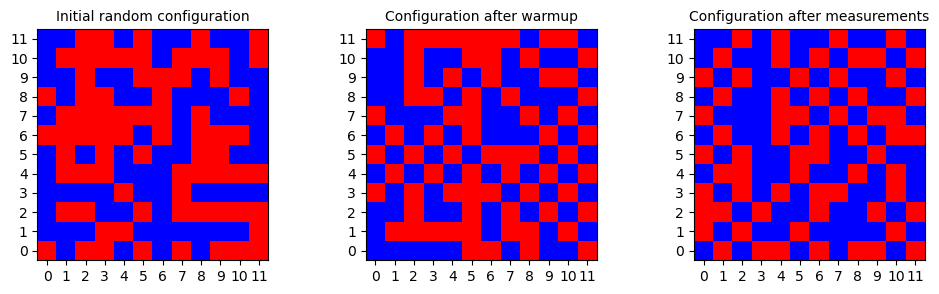

T = 2.90 statistics: 
mag_avg = -0.000472917
mag_error = 0.000684307
stag_mag_avg = 0.270559
stag_mag_error = 0.0110376






####################
##### T = 3.00 #####
####################


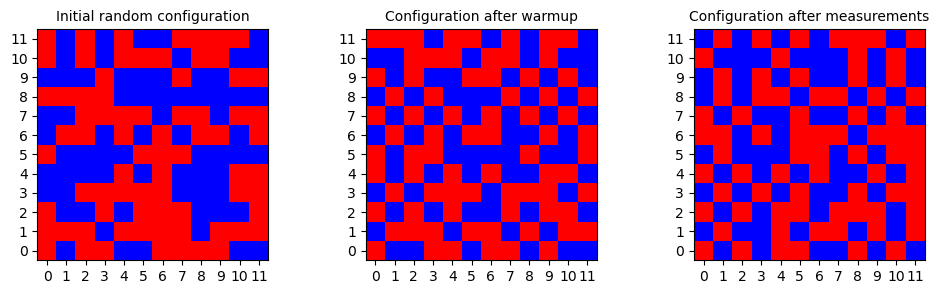

T = 3.00 statistics: 
mag_avg = 4.28819e-05
mag_error = 0.00075698
stag_mag_avg = 0.220333
stag_mag_error = 0.00792919






####################
##### T = 3.10 #####
####################


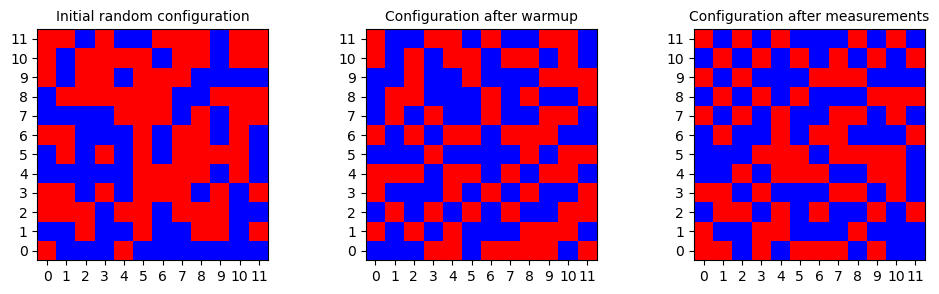

T = 3.10 statistics: 
mag_avg = -0.00137736
mag_error = 0.00144908
stag_mag_avg = 0.183251
stag_mag_error = 0.0100002






####################
##### T = 3.20 #####
####################


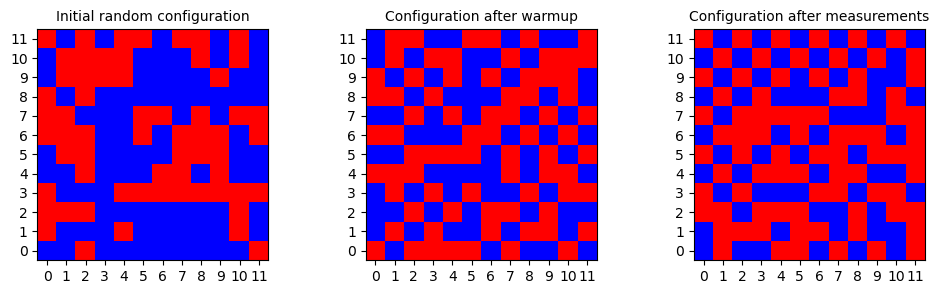

T = 3.20 statistics: 
mag_avg = -0.00185611
mag_error = 0.00160602
stag_mag_avg = 0.187958
stag_mag_error = 0.00976535






####################
##### T = 3.30 #####
####################


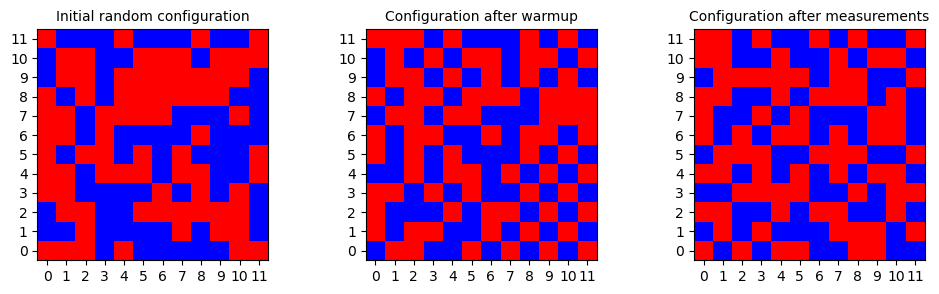

T = 3.30 statistics: 
mag_avg = -0.000902778
mag_error = 0.00168609
stag_mag_avg = 0.18422
stag_mag_error = 0.00927658






####################
##### T = 3.40 #####
####################


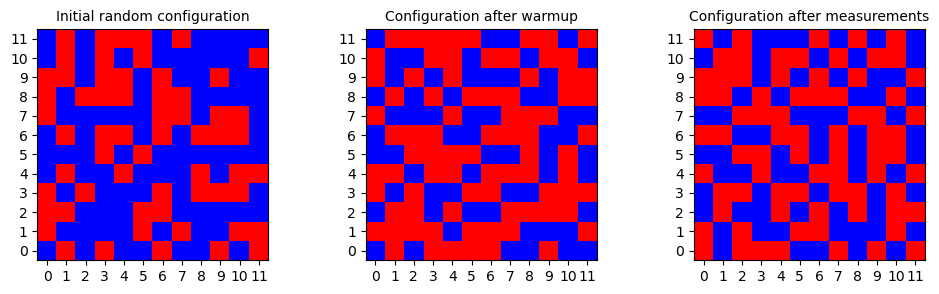

T = 3.40 statistics: 
mag_avg = -0.00304486
mag_error = 0.00169554
stag_mag_avg = 0.17862
stag_mag_error = 0.0101032






####################
##### T = 3.50 #####
####################


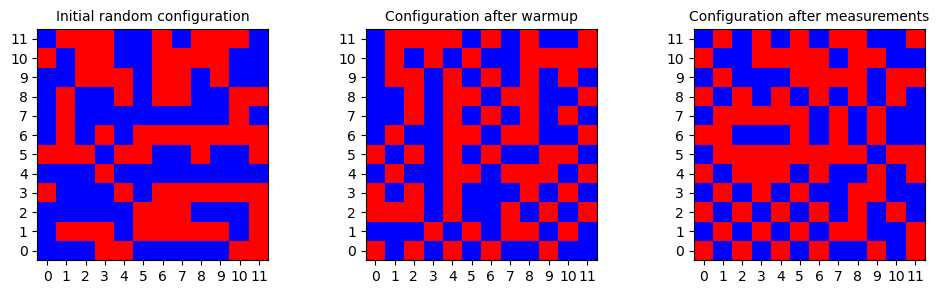

T = 3.50 statistics: 
mag_avg = -0.00198958
mag_error = 0.00161094
stag_mag_avg = 0.139341
stag_mag_error = 0.00657996






####################
##### T = 3.60 #####
####################


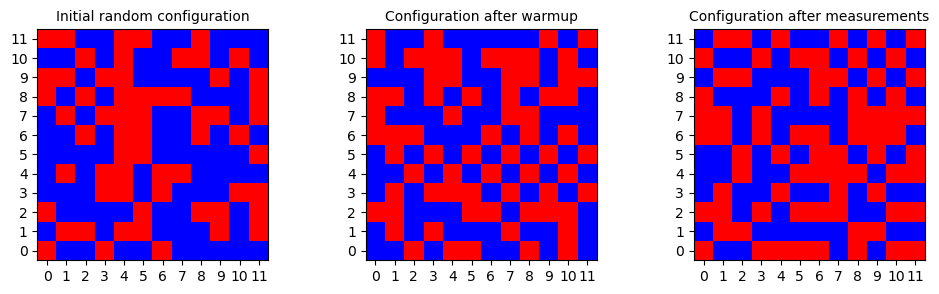

T = 3.60 statistics: 
mag_avg = 0.00240278
mag_error = 0.00146364
stag_mag_avg = 0.145781
stag_mag_error = 0.00671171






####################
##### T = 3.70 #####
####################


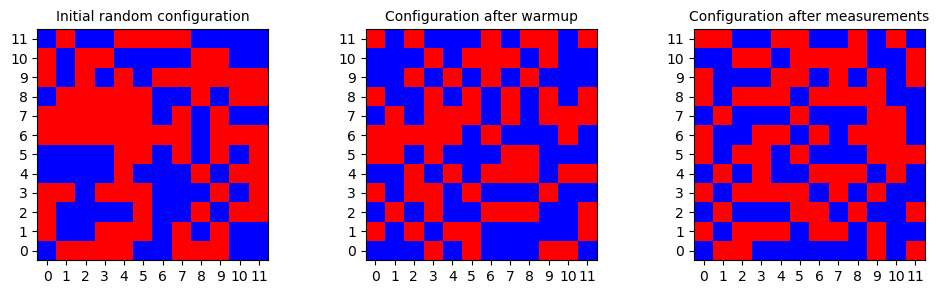

T = 3.70 statistics: 
mag_avg = -0.000434167
mag_error = 0.00176056
stag_mag_avg = 0.141765
stag_mag_error = 0.00599702






####################
##### T = 3.80 #####
####################


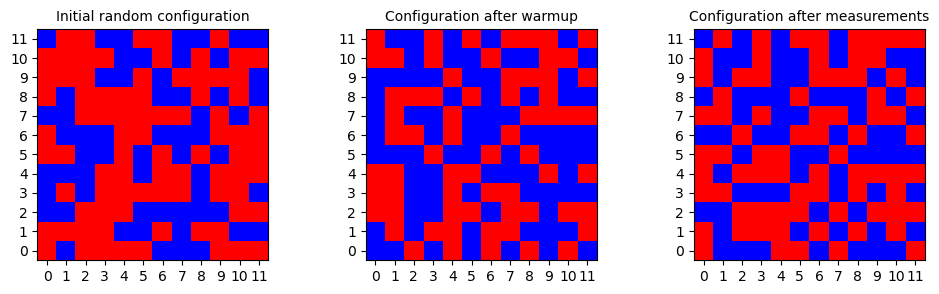

T = 3.80 statistics: 
mag_avg = -7.05556e-05
mag_error = 0.00172074
stag_mag_avg = 0.146203
stag_mag_error = 0.00604327






####################
##### T = 3.90 #####
####################


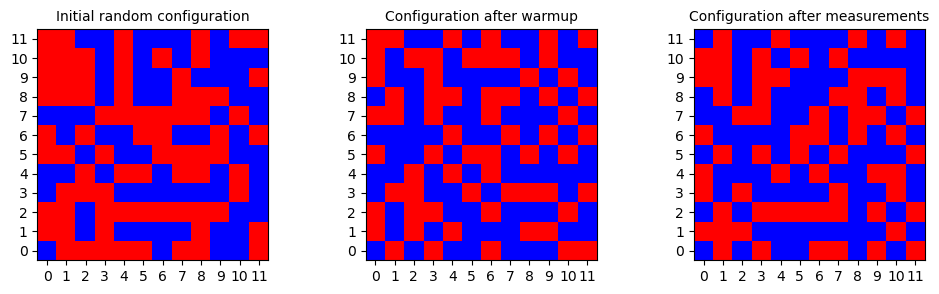

T = 3.90 statistics: 
mag_avg = 0.00432278
mag_error = 0.00162439
stag_mag_avg = 0.13459
stag_mag_error = 0.0055036






####################
##### T = 4.00 #####
####################


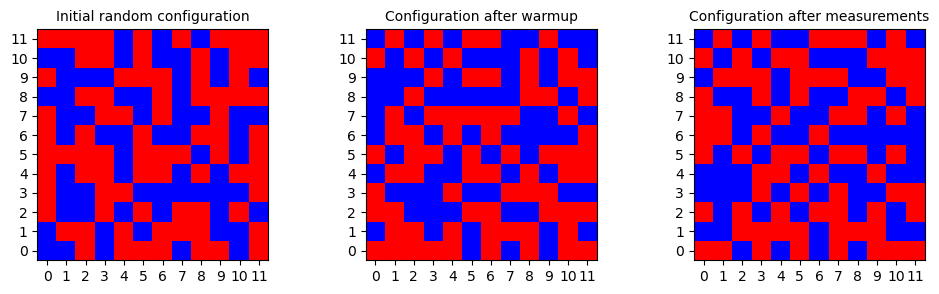

T = 4.00 statistics: 
mag_avg = 0.00243389
mag_error = 0.0015795
stag_mag_avg = 0.141602
stag_mag_error = 0.00645209






####################
##### T = 4.10 #####
####################


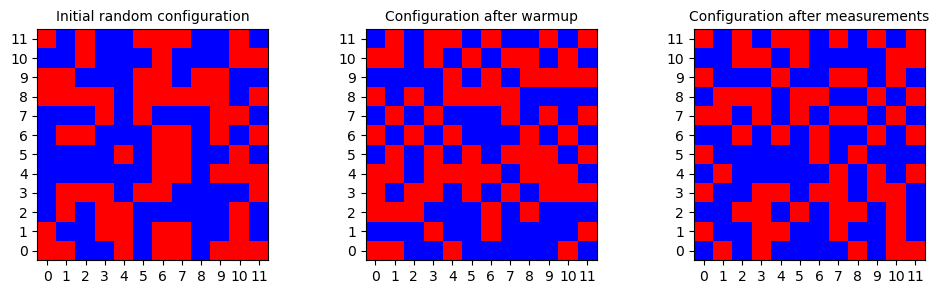

T = 4.10 statistics: 
mag_avg = -6.05556e-05
mag_error = 0.00165452
stag_mag_avg = 0.128012
stag_mag_error = 0.00507567






####################
##### T = 4.20 #####
####################


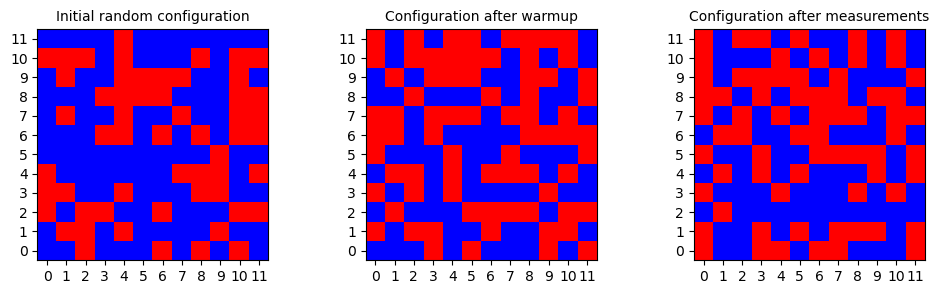

T = 4.20 statistics: 
mag_avg = 0.00167194
mag_error = 0.00171975
stag_mag_avg = 0.133838
stag_mag_error = 0.0068579






####################
##### T = 4.30 #####
####################


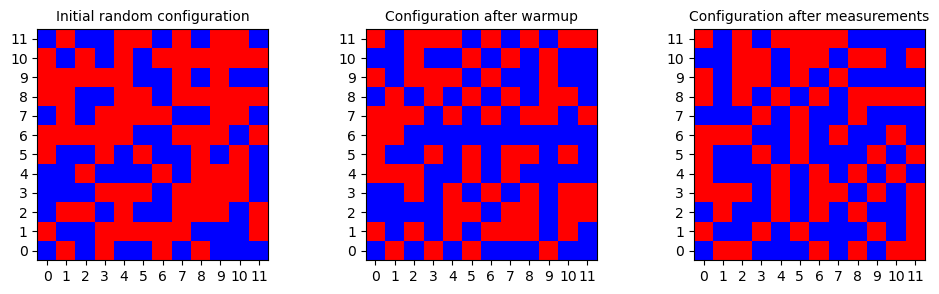

T = 4.30 statistics: 
mag_avg = -0.000435972
mag_error = 0.00170564
stag_mag_avg = 0.123676
stag_mag_error = 0.00491877






####################
##### T = 4.40 #####
####################


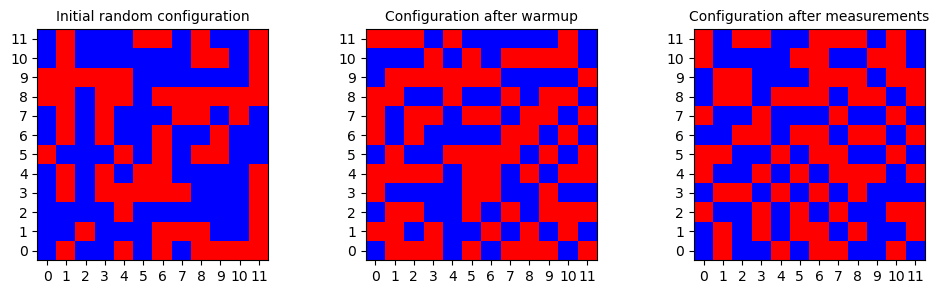

T = 4.40 statistics: 
mag_avg = 0.000127361
mag_error = 0.0015793
stag_mag_avg = 0.125918
stag_mag_error = 0.00492613






####################
##### T = 4.50 #####
####################


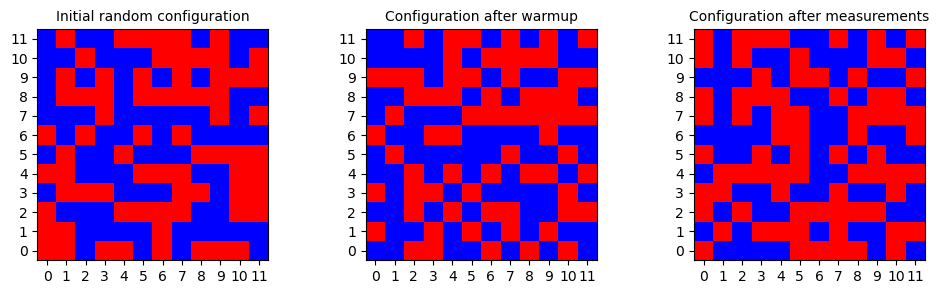

T = 4.50 statistics: 
mag_avg = -0.000465833
mag_error = 0.00168682
stag_mag_avg = 0.122962
stag_mag_error = 0.00480032






####################
##### T = 4.60 #####
####################


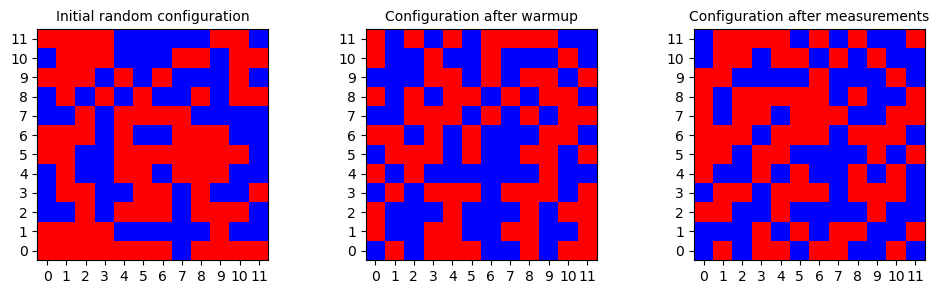

T = 4.60 statistics: 
mag_avg = 0.000460139
mag_error = 0.0019152
stag_mag_avg = 0.119842
stag_mag_error = 0.00544794






####################
##### T = 4.70 #####
####################


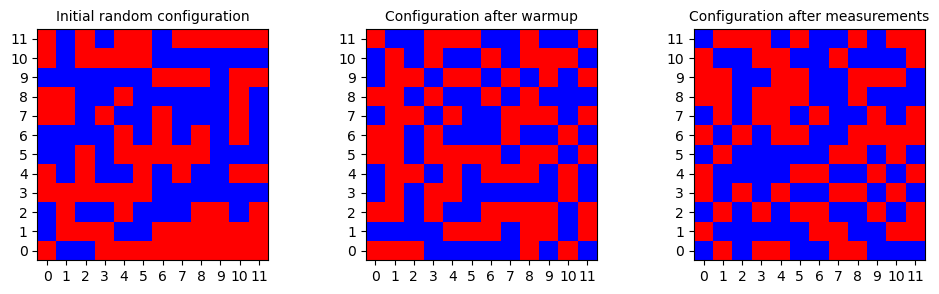

T = 4.70 statistics: 
mag_avg = 0.00168097
mag_error = 0.00177898
stag_mag_avg = 0.124333
stag_mag_error = 0.00414309






####################
##### T = 4.80 #####
####################


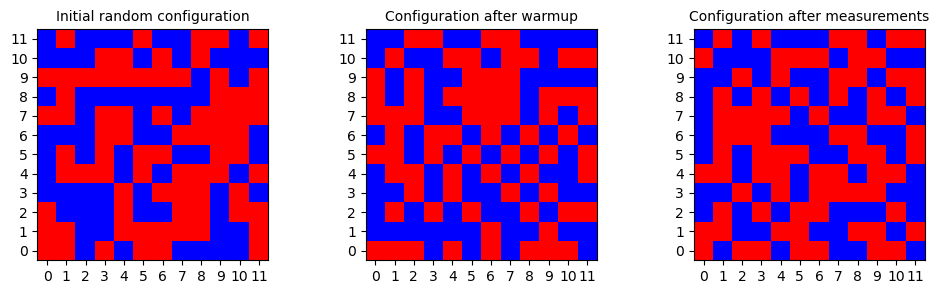

T = 4.80 statistics: 
mag_avg = 7.84722e-05
mag_error = 0.00162693
stag_mag_avg = 0.120306
stag_mag_error = 0.00437039






####################
##### T = 4.90 #####
####################


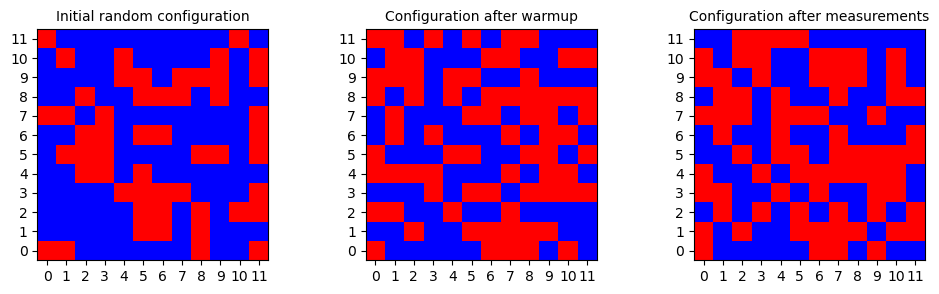

T = 4.90 statistics: 
mag_avg = -0.000212361
mag_error = 0.00183793
stag_mag_avg = 0.11133
stag_mag_error = 0.00350695






####################
##### T = 5.00 #####
####################


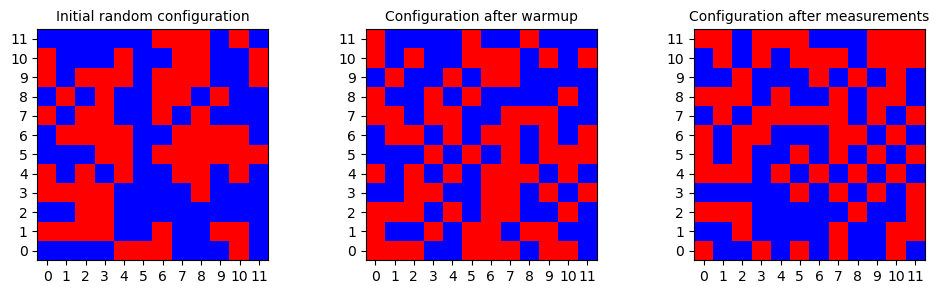

T = 5.00 statistics: 
mag_avg = -0.00101028
mag_error = 0.00188965
stag_mag_avg = 0.109746
stag_mag_error = 0.00440765








In [127]:
J = 1
L = 12
T_min = 1
T_max = 5
N_temps = 41
N_bin = 100
N_warm = 100000
N_meas = 100000
T2_min = 2
T2_max = 3
N_warm_2 = 400000
N_meas_2 = 400000

binned_configurations_array, T_array, m_array, me_array, sm_array, sme_array = simulation(J, L, T_min, T_max, N_temps, N_bin, N_warm, N_meas, T2_min, T2_max, N_warm_2, N_meas_2)

In [128]:
binned_configurations_array.shape

(4100, 145)

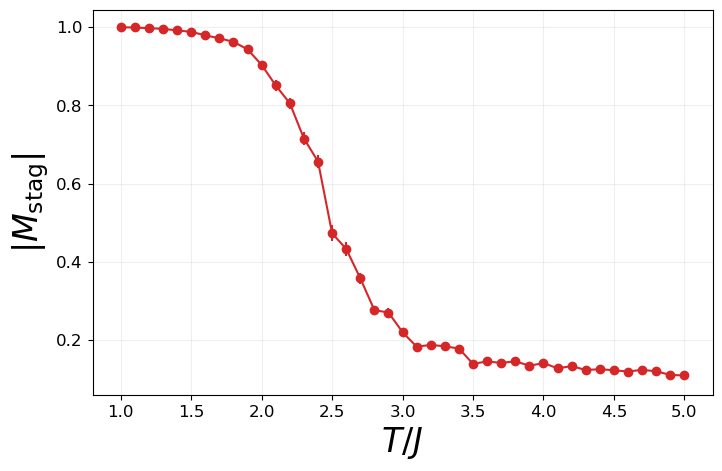

In [129]:
plt.figure(figsize=(8,5))
plt.errorbar(T_array, sm_array, yerr=sme_array, marker='o', linestyle='solid', color='tab:red')
plt.ylabel(r'$|M_{\mathrm{stag}}|$', fontsize=24)
plt.yticks(fontsize=12)
plt.xlabel(r'$T/J$', fontsize=24)
plt.xticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show()

In [130]:
binned_configurations_df = pd.DataFrame(binned_configurations_array)
binned_configurations_df.rename({144:'Temperature'}, axis=1, inplace=True)
binned_configurations_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Temperature
4090,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,5.0
4091,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,5.0
4092,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,5.0
4093,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,5.0
4094,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,5.0
4095,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,5.0
4096,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,5.0
4097,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,5.0
4098,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,5.0
4099,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,5.0


In [138]:
np.save('.\\data\\binned_configurations_array_v0.npy', binned_configurations_array)
np.savetxt('.\\data\\binned_configurations_array_v0.csv', binned_configurations_array, delimiter=',')